In [1]:
#import numpy as np
import pandas as pd
from scipy import optimize as opt
import autograd
from autograd import numpy as np  
import matplotlib.pyplot as plt

In [2]:
def newton_p1(f, x0, maxiter=1000, tol=1e-5):
    iters = 0
    diff = 1
    converged = False
    Df = autograd.jacobian(f)
    D2f = autograd.hessian(f)

    x = x0.copy()
    x_old = x0.copy()
    while (iters < maxiter) and (diff > tol):
        Df_x = np.array(Df(x_old))
        D2f_x = np.array(D2f(x_old))
        x = x_old -np.linalg.solve(D2f_x, Df_x)
        diff = np.abs(Df_x).max()
        x_old = x.copy()
        iters +=1
    
    if iters <maxiter:
        converged=True
    
    return x, converged, iters

In [3]:
f = lambda x: 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

In [4]:
x, converged, iters =newton_p1(f, np.array([-2., 2.]))
# Can't get this damn warning to go away...

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [5]:
opt.fmin_bfgs(f=opt.rosen, x0=[-2, 2], fprime=opt.rosen_der)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


array([1.00000021, 1.00000045])

## Problem 2

In [6]:
def get_A(A_old, s, y, n):
    s = s.reshape(n, 1)
    y = y.reshape(n, 1)
    if np.dot(s.T, y) == 0:
        return A_old
    
    else:
        part1 = (s.T @ y+y.T @(A_old @y))*(s @ s.T)
        part1 /= (s.T @ y)**2

        part2 = A_old @ (y @ s.T) + s @ (y.T @ A_old)
        part2 /= (s.T @ y)

        return A_old+part1-part2
    
def BFGS_p2(f, x0, maxiter=1000, tol=1e-5):
    iters = 0
    diff = 1
    converged = False
    Df = autograd.jacobian(f)
    n = x0.shape[0]
    
    x = x0.copy()
    x_old = x0.copy()
    
    A = np.eye(n)
    A_old = A.copy()
    
    Df_x = Df(x0)
    Df_x_old = Df(x0)
    
    while (iters < maxiter) and (diff > tol):
        
        x = x_old -np.dot(A_old, Df_x_old)
        Df_x = Df(x)
        
        s = x-x_old
        y = Df_x - Df_x_old
        A = get_A(A_old, s, y, n)
        
        diff = np.abs(Df_x).max()
        x_old = x.copy()
        A_old = A.copy()
        Df_x_old = Df_x.copy()
        iters +=1
    
    if iters <maxiter:
        converged=True
    
    return x, converged, iters

In [7]:
f = lambda x: 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

In [9]:
BFGS_p2(f, np.array([-2., 2.]))

(array([0.99999999, 0.99999998]), True, 107)

## Problem 3

In [10]:
import time

def simulate(N):
    scipy_opt = lambda f, x: opt.fmin_bfgs(f, x, \
                        fprime= autograd.jacobian(f),\
                                           disp=False, retall=True)
    functions = {'Newton':newton_p1, 'BFGS':BFGS_p2, \
                 'scipy':scipy_opt}
    output = {'Newton':[], 'BFGS':[], 'scipy':[]}
    
    for i in range(N):
        x = np.random.uniform(-3, 3, 2)
        for j in ['Newton', 'BFGS']:
            start = -time.time()
            xC, converged, iters = functions[j](f, x)
            start += time.time()
            output[j].append([iters, start])
        
        j = 'scipy'
        start = -time.time()
        iters = len(functions[j](f, x)[1])
        start += time.time()
        output[j].append([iters, start])
        
    for i in list(output.keys()):
        output[i] = np.array(output[i])
        
    fig, ax = plt.subplots(figsize=(10,5))
    for i in list(output.keys()):
        ax.semilogy(output[i][:,1], output[i][:,0], '*',label=i)
    ax.legend()
    ax.set_title('Convergence of jacobi Method')
    ax.set_xscale('log')
    ax.set_ylabel('Iteration')
    ax.set_xlabel('Time')

    plt.show()
    
    return output
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


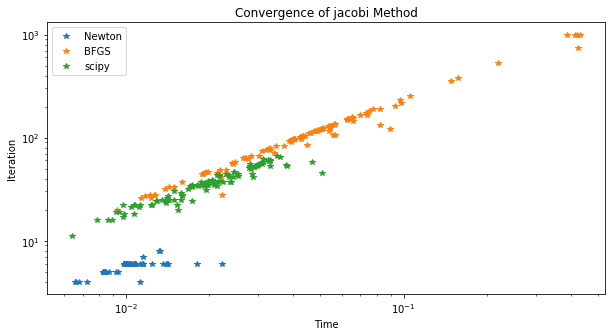

In [11]:
output = simulate(100)

## Problem 4

In [12]:
def gauss_newton_p4(res, x0, maxiter=1000, tol=1e-5):
    iters = 0
    diff = 1
    converged = False
    
    Dr = autograd.jacobian(res)
    
    x = x0.copy()
    x_old = x0.copy()
    while (iters < maxiter) and (diff > tol):
        Dr_x = Dr(x_old)
        res_x = res(x_old)
        part1 = np.linalg.inv(Dr_x.T @ Dr_x)
        part2 =  (Dr_x.T @ res_x)
        x = x_old - (part1 @ part2)
        diff = np.abs(x-x_old).max()
        x_old = x.copy()
        iters +=1
    
    if iters <maxiter:
        converged=True
    
    return x, converged, iters

In [16]:
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)

model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y     
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))

In [17]:
x, conv, niters = gauss_newton_p4(residual, np.array([2.5, .6]))

In [23]:
x2 = opt.leastsq(func=residual, x0=np.array([2.5, .6]), Dfun=jac)[0]

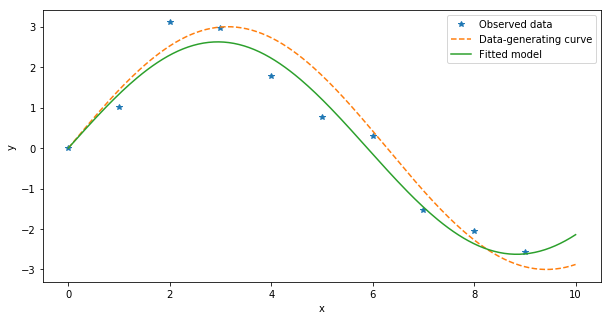

In [28]:
dom = np.linspace(0, 10, 200)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(T, y, '*', label='Observed data')
ax.plot(dom, 3*np.sin(.5*dom), '--', label='Data-generating curve')
ax.plot(dom, model(x, dom), label='Fitted model')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

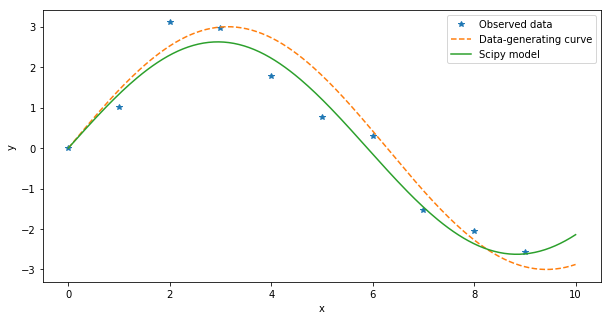

In [27]:
dom = np.linspace(0, 10, 200)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(T, y, '*', label='Observed data')
ax.plot(dom, 3*np.sin(.5*dom), '--', label='Data-generating curve')
ax.plot(dom, model(x2, dom), label='Scipy model')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

## Problem 5

In [30]:
np.load('population.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'population.npy'

In [26]:
x

array([2.62506912, 0.53298165])